# RL moments

To demonstrate how to calculate RL moments, I'll use a new set of LOSVD models called convolution models (Jethwa et al. in prep). 

Convolution models take five parameters:
- $V$ = mean,
- $\sigma$ = standard deviation,
- $\sigma_K \geq 0$ controls overall magnitude of non-gaussianity,
- $-0.6 < \delta < 0.6$ controls skewness
- $-1< \kappa < 1$ controls kurtosis

In [54]:
import momoments.rl_moments as rlm

rl skewness = 0.17125885569133412
rl kurtosis = 2.687312955710085e-05
rl skewness = 0.25653799942900607
rl kurtosis = 0.13606726184606627


(0.001, 0.1)

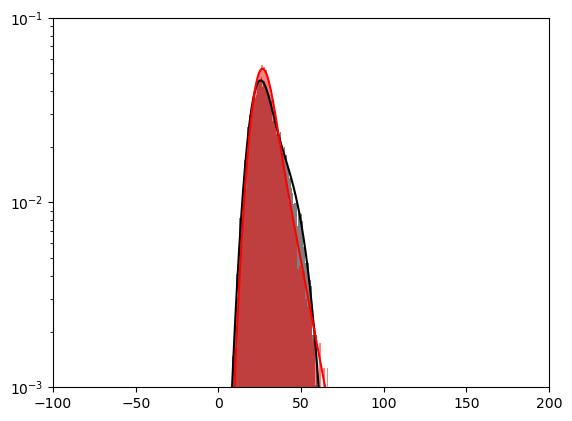

In [55]:
import convmods.convmods as cnv
import numpy as np
import matplotlib.pyplot as plt

V, sigma = 30, 10
sigmaK, delta, kappa = 1.5, 0.5, -1

# initialise a convolution model LOSVD
kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa, pkernel_type='triangle')
losvd = cnv.LOSVD(V=V, sigma=sigma, kernel=kernel)

# plot pdf
v, pdf = losvd.evaluate_via_fft(vmax=300., nv=1001)
plt.plot(v, pdf, '-k')

# plot histogram of samples drawn from LOSVD
v_smp = losvd.rvs(10000)
h, v_edg, _ = plt.hist(v_smp, density=True, bins=100, alpha=0.5, color='k')

rl_moms = rlm.sample_rl_moments(v_smp)
rl_moms = np.squeeze(rl_moms)
print(f'rl skewness = {rl_moms[0]}')
print(f'rl kurtosis = {rl_moms[1]}')

V, sigma = 30, 10
sigmaK, delta, kappa = 1.5, 0.5, 1

# initialise a convolution model LOSVD
kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa)
losvd = cnv.LOSVD(V=V, sigma=sigma, kernel=kernel)

# plot pdf
v, pdf = losvd.evaluate_via_fft(vmax=300., nv=1001)
plt.plot(v, pdf, '-r')

# plot histogram of samples drawn from LOSVD
v_smp = losvd.rvs(10000)
h, v_edg, _ = plt.hist(v_smp, density=True, bins=100, alpha=0.5, color='r')

rl_moms = rlm.sample_rl_moments(v_smp)
rl_moms = np.squeeze(rl_moms)
print(f'rl skewness = {rl_moms[0]}')
print(f'rl kurtosis = {rl_moms[1]}')

plt.gca().set_xlim(-100, 200)
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-3, 0.1)


We can calculate the RL moments in two ways. First, using the estimator for discrete samples,

And, secondly, using the integral over the LOSVD,

In [56]:
v, pdf = losvd.evaluate_via_fft(vmax=200., nv=1000001)
dv = v[1] - v[0]
v_edg = np.concatenate(([v[0]-dv/2], v+dv/2.))

rl_moments_from_integral = rlm.integral_rl_moments(pdf, v_edg)
rl_moments_from_integral = np.squeeze(rl_moments_from_integral)
print(f'rl skewness = {rl_moments_from_integral[0]}')
print(f'rl kurtosis = {rl_moments_from_integral[1]}')

rl skewness = 0.2505766256784803
rl kurtosis = 0.1192514458884421


The two estimators should approach one another as (i) the number of samples increases in the sample estimator, and (ii) the discretisation od the integration is fine enough (large `nv`) and over a large enough extent (large `vmax`).

The integral form is also vectorised, so we can quickly calculate RL moments of a large number of evaluated LOSVDs. For example, let's take a set of convolution models with a 3D grid of paramaters $(\sigma_K, \delta, \kappa)$:

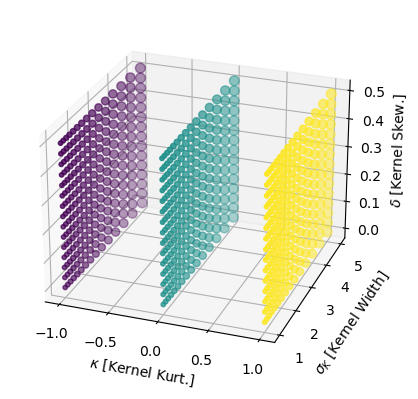

In [57]:
sigmaK_arr = np.logspace(0, np.log10(5.), 15)
delta_arr = np.linspace(0, 0.5, 15)
kappa_arr = [-1, 0, 1]

V, sigma = 0, 1
vmax, nv = 10, 10001

ss, dd, kk = np.meshgrid(sigmaK_arr, delta_arr, kappa_arr, indexing='ij')
sigmaK_list = np.ravel(ss)
delta_list = np.ravel(dd)
kappa_list = np.ravel(kk)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(kappa_list, sigmaK_list, delta_list, c=kappa_list, s=sigmaK_list*10)
ax.set_xlabel('$\kappa$ [Kernel Kurt.]')
ax.set_ylabel('$\sigma_K$ [Kernel Width]')
ax.set_zlabel('$\delta$ [Kernel Skew.]')
ax.azim -= 10
ax.elev -= 5

Let's evaluate the models,

In [58]:
evaluated_losvds = []
for sigmaK, delta, kappa in zip(sigmaK_list, delta_list, kappa_list):
    kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa)
    losvd = cnv.LOSVD(V=0, sigma=1, kernel=kernel)
    v, pdf = losvd.evaluate_via_fft(vmax=10, nv=10001)
    evaluated_losvds += [list(pdf)]
evaluated_losvds = np.array(evaluated_losvds)

and calculate the RL moments of all the models as follows,

(-0.2, 0.2)

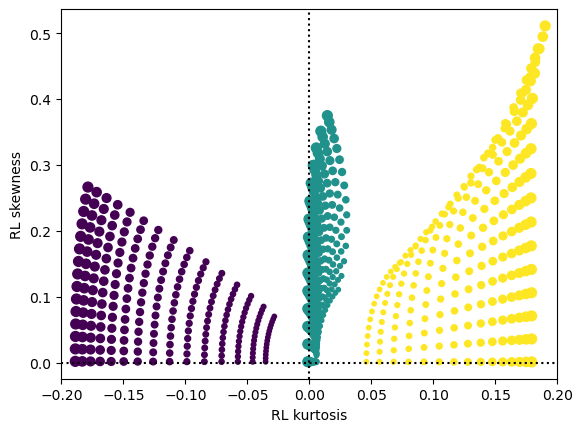

In [59]:
dv = v[1] - v[0]
v_edg = np.concatenate(([v[0]-dv/2], v+dv/2.))

rlmoms = rlm.integral_rl_moments(evaluated_losvds, v_edg)

plt.scatter(rlmoms[1], rlmoms[0], c=kappa_list, s=sigmaK_list*10)
plt.gca().set_xlabel('RL kurtosis')
plt.gca().set_ylabel('RL skewness')
plt.gca().axhline(0, ls=':', color='k')
plt.gca().axvline(0, ls=':', color='k')

plt.gca().set_xlim(-0.2, 0.2)

Changing the platykurtic component of the convolution model kernel from `uniform` to `cosine` gives,

(-0.2, 0.2)

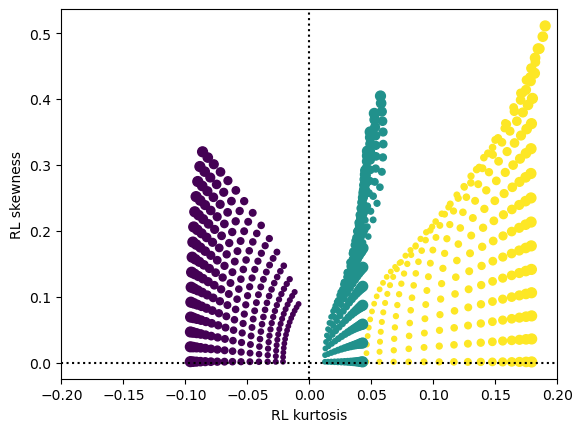

In [60]:
evaluated_losvds2 = []
for sigmaK, delta, kappa in zip(sigmaK_list, delta_list, kappa_list):
    kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa, pkernel_type='cosine')
    losvd = cnv.LOSVD(V=0, sigma=1, kernel=kernel)
    v, pdf = losvd.evaluate_via_fft(vmax=10, nv=10001)
    evaluated_losvds2 += [list(pdf)]
evaluated_losvds2 = np.array(evaluated_losvds2)

rlmoms2 = rlm.integral_rl_moments(evaluated_losvds2, v_edg)
rlmoms2.shape

plt.scatter(rlmoms2[1], rlmoms2[0], c=kappa_list, s=sigmaK_list*10)
plt.gca().set_xlabel('RL kurtosis')
plt.gca().set_ylabel('RL skewness')
plt.gca().axhline(0, ls=':', color='k')
plt.gca().axvline(0, ls=':', color='k')

plt.gca().set_xlim(-0.2, 0.2)

... and changing it to the triangle gives,

(-0.2, 0.2)

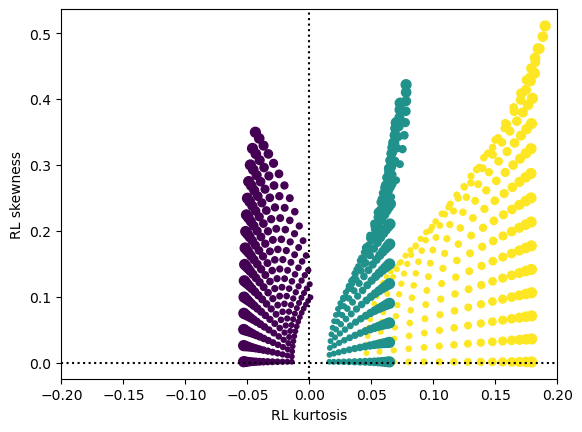

In [61]:
evaluated_losvds3 = []
for sigmaK, delta, kappa in zip(sigmaK_list, delta_list, kappa_list):
    kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa, pkernel_type='triangle')
    losvd = cnv.LOSVD(V=0, sigma=1, kernel=kernel)
    v, pdf = losvd.evaluate_via_fft(vmax=10, nv=10001)
    evaluated_losvds3 += [list(pdf)]
evaluated_losvds3 = np.array(evaluated_losvds3)

rlmoms3 = rlm.integral_rl_moments(evaluated_losvds3, v_edg)

plt.scatter(rlmoms3[1], rlmoms3[0], c=kappa_list, s=sigmaK_list*10)
plt.gca().set_xlabel('RL kurtosis')
plt.gca().set_ylabel('RL skewness')
plt.gca().axhline(0, ls=':', color='k')
plt.gca().axvline(0, ls=':', color='k')

plt.gca().set_xlim(-0.2, 0.2)

In [62]:
dv = v[1] - v[0]

In [63]:
grad_losvd = np.gradient(evaluated_losvds, dv, axis=1)
gradcos_losvd = np.gradient(evaluated_losvds2, dv, axis=1)
gradtri_losvd = np.gradient(evaluated_losvds3, dv, axis=1)


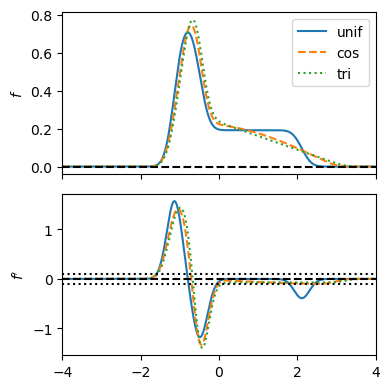

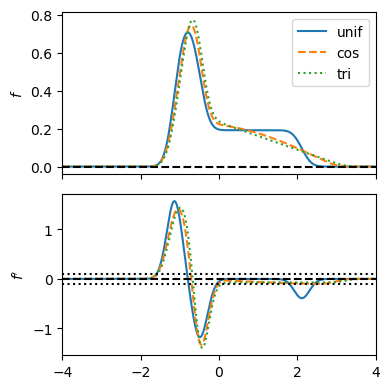

In [64]:
def plot_mods_and_grads(i=None, par_idx=None, grad_lim=0.1):

    if par_idx is not None:
        i, j, k = par_idx
        idx = np.where(
            (sigmaK_list == np.unique(sigmaK_list)[i]) & 
            (delta_list == np.unique(delta_list)[j]) & 
            (kappa_list == np.unique(kappa_list)[k])
        )
        i = idx[0][0]

    fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

    ax[0].plot(v, evaluated_losvds[i], label='unif')
    ax[1].plot(v, grad_losvd[i])

    ax[0].plot(v, evaluated_losvds2[i], '--', label='cos')
    ax[1].plot(v, gradcos_losvd[i], '--')

    ax[0].plot(v, evaluated_losvds3[i], ':', label='tri')
    ax[1].plot(v, gradtri_losvd[i], ':')

    ax[1].axhline(grad_lim, ls=':', color='k')
    ax[1].axhline(-grad_lim, ls=':', color='k')

    ax[0].set_ylabel('$f$')
    ax[1].set_ylabel("$f'$")

    ax[0].legend()
    for ax0 in ax:
        ax0.axhline(0, ls='--', color='k')
    ax[0].set_xlim(-4,4)
    fig.tight_layout()

    return fig

plot_mods_and_grads(-3)


Using the integrated absolute third derivative.

In [65]:
def get_n_signchanges(a):
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1, axis=1) - asign) != 0).astype(int)
    signchange[:,0] = 0
    n_signchanges = np.sum(signchange, 1)
    return n_signchanges

In [66]:
grad_lim = 0.05

a = np.array(np.abs(grad_losvd) < grad_lim, dtype=int)-0.5
n_plateau = get_n_signchanges(a) - 3

a = np.array(np.abs(gradcos_losvd) < grad_lim, dtype=int)-0.5
n_plateau_cos = get_n_signchanges(a) - 3

a = np.array(np.abs(gradtri_losvd) < grad_lim, dtype=int)-0.5
n_plateau_tri = get_n_signchanges(a) - 3

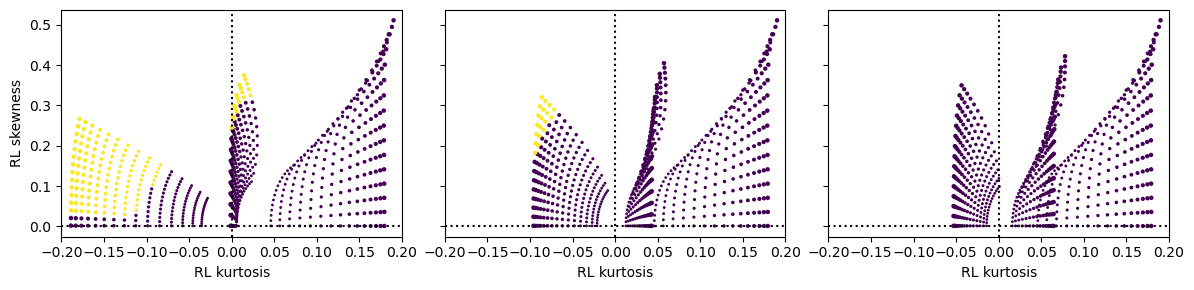

In [67]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))

for ax0, rl, nplateau in zip(ax, [rlmoms, rlmoms2, rlmoms3], [n_plateau, n_plateau_cos, n_plateau_tri]):
    ax0.scatter(rl[1], rl[0], c=nplateau, s=sigmaK_list, vmin=1, vmax=2)
    ax0.axhline(0, ls=':', color='k')
    ax0.axvline(0, ls=':', color='k')
    ax0.set_xlabel('RL kurtosis')
    
ax[0].set_ylabel('RL skewness')
ax[0].set_xlim(-0.2, 0.2)
fig.tight_layout()

The maximum moments of the model saturate at the max moments of the kernel. 

Yellow points have two peak/plateaus, purple points have one.

What does this classification boundary look like? First look at the boundary for uniform:

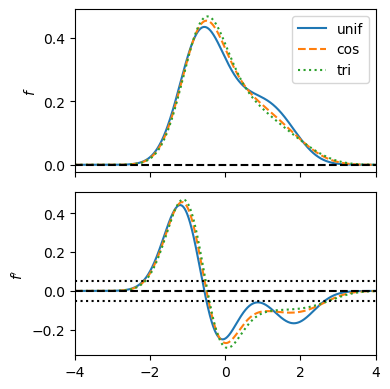

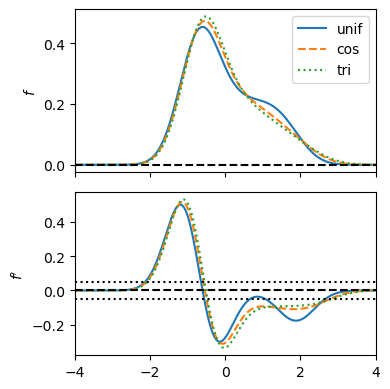

In [74]:
for i in [4,5]:
    plot_mods_and_grads(par_idx=[i, -1, 0], grad_lim=grad_lim)

and for cos kernel:

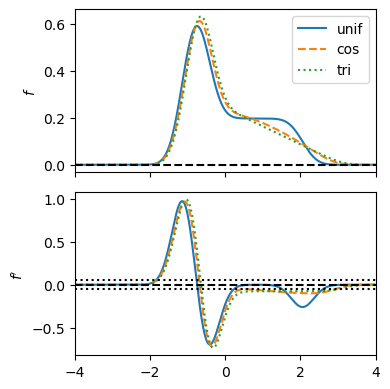

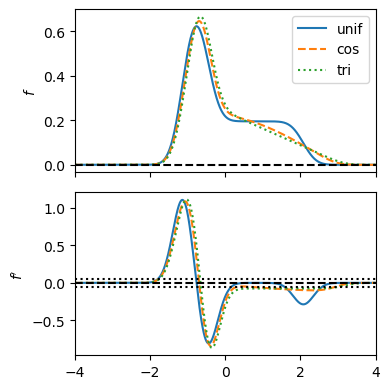

In [75]:
for i in [10,11]:
    plot_mods_and_grads(par_idx=[i, -1, 0], grad_lim=grad_lim)

## Extending beyond delta limits

In [70]:
# sigmaK_arr = np.linspace(0.5, 3., 10)
# delta_arr = np.linspace(0, 1.7, 18)
# kappa_arr = [-1, 1]

# V, sigma = 0, 1
# vmax, nv = 10, 10001

# ss, dd, kk = np.meshgrid(sigmaK_arr, delta_arr, kappa_arr, indexing='ij')
# sigmaK_list = np.ravel(ss)
# delta_list = np.ravel(dd)
# kappa_list = np.ravel(kk)

# evaluated_losvds = []
# for sigmaK, delta, kappa in zip(sigmaK_list, delta_list, kappa_list):
#     kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa, which_delta_limit=None)
#     losvd = cnv.LOSVD(V=0, sigma=1, kernel=kernel)
#     v, pdf = losvd.evaluate_via_fft(vmax=10, nv=5001)
#     evaluated_losvds += [list(pdf)]
# evaluated_losvds = np.array(evaluated_losvds)

# dv = v[1] - v[0]
# v_edg = np.concatenate(([v[0]-dv/2], v+dv/2.))

# rlmoms = rlm.integral_rl_moments(evaluated_losvds, v_edg)

# plt.scatter(rlmoms[1], rlmoms[0], c=sigmaK_list)
# plt.gca().set_xlabel('RL kurtosis')
# plt.gca().set_ylabel('RL skewness')
# plt.gca().axhline(0, ls=':', color='k')
# plt.gca().axvline(0, ls=':', color='k')